<a href="https://colab.research.google.com/github/debashisdotchatterjee/Cosmic-Colours-and-X-ray-Part-1/blob/main/Xray_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from IPython.display import display

df = pd.read_csv('xwas_agn_clean.csv')
display(df.head(10))

,Name,ObsID,RA_deg,Dec_deg,z,Class,Flux_0p5_4p5,Log_Lx,SCID,Bmag,Rmag,BR_color
0,XWAS J000002.7-251136,X21207_032,0.011125,-25.193556,1.314,BLAGN,3.1,44.50,283502201403207,21.33,21.79,-0.46
1,XWAS J000021.2-250812,X21207_051,0.088208,-25.136861,0.995,BLAGN,2.2,44.04,283502201406064,20.89,20.51,0.38
2,XWAS J000022.8-251222,X21207_028,0.095167,-25.206389,1.600,BLAGN,2.5,44.61,283502201402588,19.92,21.05,-1.13
3,XWAS J000025.3-251141,X21207_031,0.105792,-25.194833,0.090,Gal,0.4,40.92,283502201403144,16.35,17.52,-1.17
4,XWAS J000025.4-245421,X21207_112,0.106458,-24.905778,0.720,BLAGN,1.7,43.59,283502201418119,19.12,20.43,-1.31
5,XWAS J000026.0-250649,X21207_058,0.108583,-25.113972,0.433,BLAGN,2.0,43.12,283502201407236,20.58,21.41,-0.83
6,XWAS J000029.8-251213,X21207_029,0.124292,-25.204750,0.160,Gal,7.1,42.70,283502201402660,17.39,19.17,-1.78
7,XWAS J000031.8-245501,X21207_110,0.132875,-24.916639,0.286,NELG,10.2,43.42,283502201417551,20.12,NaN,NaN
8,XWAS J000033.1-250917,X21207_046,0.138208,-25.155500,0.324,NELG,0.2,41.87,283502201405124,19.01,20.80,-1.79
9,XWAS J000034.6-250620,X21207_060,0.144333,-25.105944,1.232,BLAGN,3.0,44.42,283502201407669,19.80,22.07,-2.27


In [ ]:
!pip install ace-tools

In [3]:
!pip install pingouin

→ Parsing raw catalogue …
  Clean catalogue saved → outputs/xwas_agn_clean.csv  (N=819)

===== Descriptive stats =====
              count    mean    std     min     25%    50%     75%      max
z             819.0   1.219  0.891   0.017   0.338   1.13   1.904    4.246
Flux_0p5_4p5  819.0   4.126  8.827   0.100   1.000   2.00   4.150  125.300
Log_Lx        819.0  43.825  1.177  39.830  43.170  44.23  44.670   45.950
Bmag          819.0  19.544  1.498  13.500  18.730  19.70  20.500   22.860
Rmag          697.0  20.318  1.393  14.490  19.640  20.53  21.230   23.540
BR_color      697.0  -1.119  0.691  -3.480  -1.510  -1.08  -0.630    0.670

===== Optical-class counts =====
Class
BLAGN    613
NELG     148
Gal       58
Name: count, dtype: int64


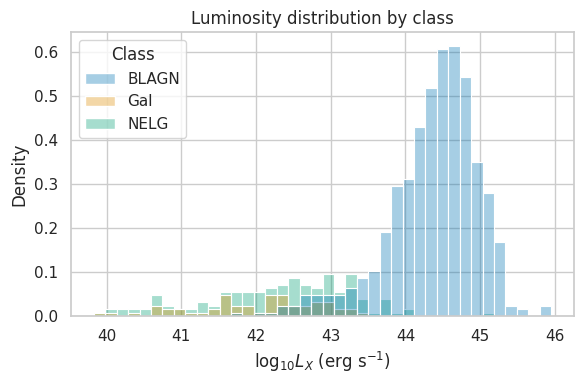

/tmp/ipython-input-8-3451081096.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(cat, x="Class", y="Log_Lx", palette="Set2")


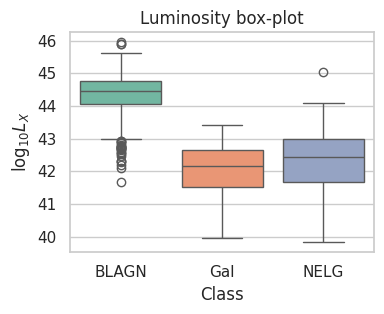

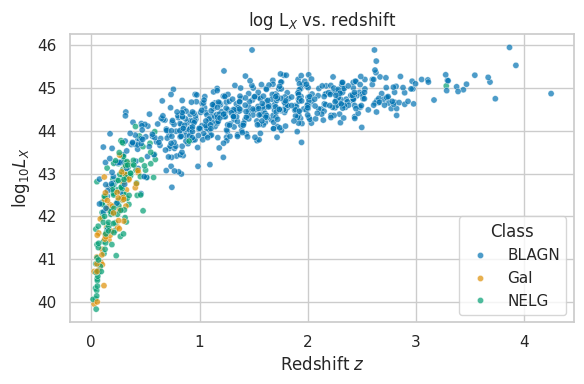

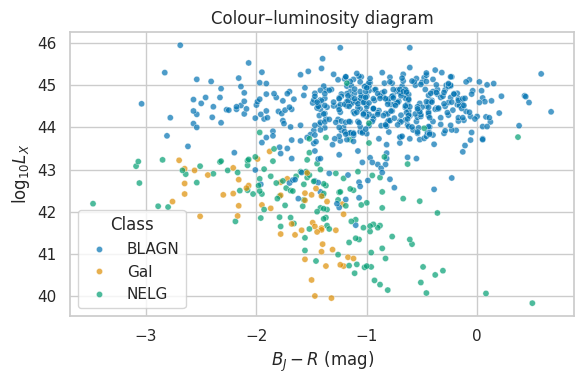

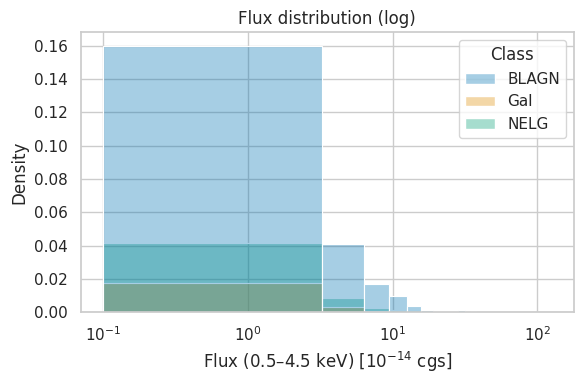

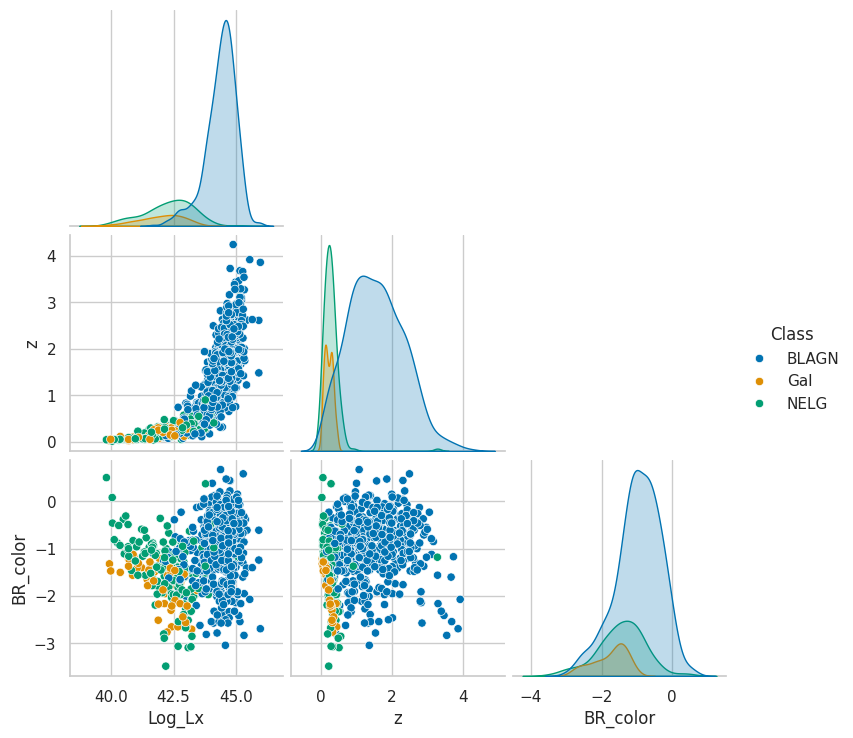

/tmp/ipython-input-8-3451081096.py:131: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = stats.anderson_ksamp([blagn, nelg])



===== Hypothesis tests =====
  Hyp  Statistic  one-tailed p
0  H1   24.65746       0.00000
1  H2    0.74214       0.00000
2  H3   -2.52683       0.99413
3  H4  242.45872       0.00001


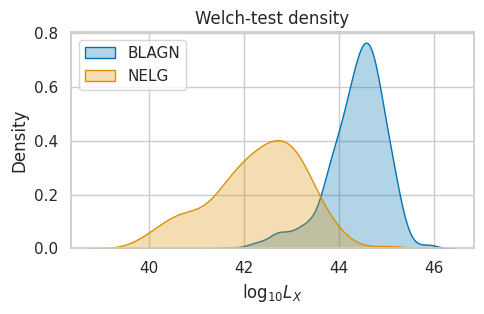

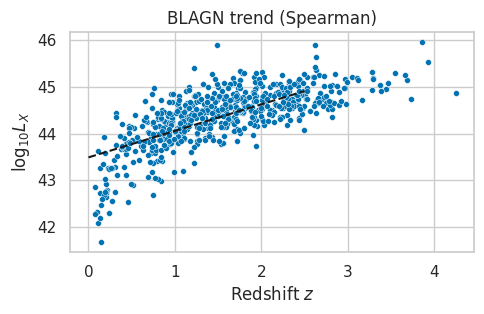

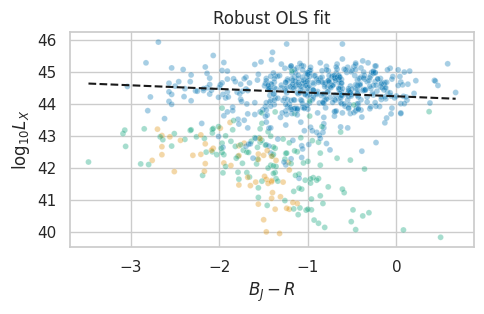

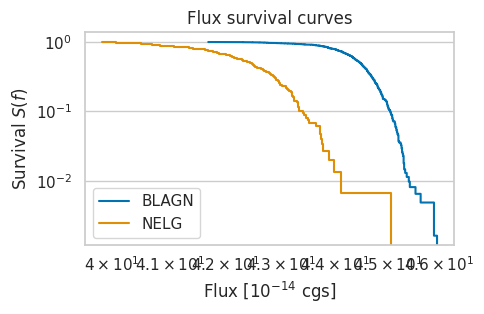


✓ Figures → outputs/figures
✓ Tables  → outputs/tables


In [8]:
#!/usr/bin/env python3
# ================================================================
#  make_xwas_figs_tables.py
#  Reproduce all figures & tables for the XWAS AGN paper
#  (no machine-learning section)
# ================================================================
import os, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind

warnings.filterwarnings("ignore", category=RuntimeWarning)
sns.set_theme(style="whitegrid", palette="colorblind")

RAW_FILE = Path("xwas_cat.dat.txt")
OUT_DIR  = Path("outputs"); FIG = OUT_DIR/"figures"; TAB = OUT_DIR/"tables"
for d in (FIG, TAB): d.mkdir(parents=True, exist_ok=True)

# -----------------------------------------------------------------
# 1. Parse CDS ascii table → DataFrame
# -----------------------------------------------------------------
def parse_catalog(fp: Path) -> pd.DataFrame:
    rows = []
    with fp.open() as fh:
        for ln in fh:
            if ln.startswith("#") or not ln.strip(): continue
            toks = ln.split()
            if len(toks) < 15: continue  # malformed
            ra_deg = 15*(float(toks[3]) + float(toks[4])/60 + float(toks[5])/3600)
            dec_d  = float(toks[6]);  sign = -1 if dec_d < 0 else 1
            dec_deg= sign*(abs(dec_d) + float(toks[7])/60 + float(toks[8])/3600)
            rows.append(dict(
                Name   = f"{toks[0]} {toks[1]}",
                ObsID  = toks[2],
                RA_deg = ra_deg,
                Dec_deg= dec_deg,
                z      = float(toks[9]),
                Class  = toks[10],
                Flux_0p5_4p5 = float(toks[11]),
                Log_Lx = float(toks[12]),
                SCID   = toks[13],
                Bmag   = np.nan if toks[14] == "…" else float(toks[14]),
                Rmag   = np.nan if len(toks)==15 or toks[15] == "…" else float(toks[15])
            ))
    df = pd.DataFrame(rows)
    df = (df[df.Class != "star"]
          .drop_duplicates("SCID", keep="first")          # <-- deduplicate
          .assign(BR_color=lambda d: d.Bmag - d.Rmag))
    return df

print("→ Parsing raw catalogue …")
cat = parse_catalog(RAW_FILE)
print(f"  Clean catalogue saved → outputs/xwas_agn_clean.csv  (N={len(cat)})")
cat.to_csv(OUT_DIR/"xwas_agn_clean.csv", index=False)

NUMERIC = ["z","Flux_0p5_4p5","Log_Lx","Bmag","Rmag","BR_color"]

# -----------------------------------------------------------------
# 2. Tables: print and save
# -----------------------------------------------------------------
desc = cat[NUMERIC].describe().T.round(3)
print("\n===== Descriptive stats ====="); print(desc)
desc.to_csv(TAB/"descriptive_stats.csv")

counts = cat.Class.value_counts()
print("\n===== Optical-class counts ====="); print(counts)
counts.to_csv(TAB/"class_counts.csv", header=True)

# -----------------------------------------------------------------
# 3. Helper to save & display figs
# -----------------------------------------------------------------
def save_show(label, w=6, h=4):
    plt.gcf().set_size_inches(w,h)
    plt.tight_layout(); plt.savefig(FIG/f"{label}.png", dpi=300)
    plt.show()

# -----------------------------------------------------------------
# 4. Figures (match paper names)
# -----------------------------------------------------------------
sns.histplot(cat, x="Log_Lx", hue="Class", stat="density",
             bins=40, alpha=.35)
plt.xlabel(r"log$_{10} L_X$ (erg s$^{-1}$)")
plt.title("Luminosity distribution by class")
save_show("hist_logLx_by_class")

sns.boxplot(cat, x="Class", y="Log_Lx", palette="Set2")
plt.ylabel(r"log$_{10} L_X$")
plt.title("Luminosity box-plot")
save_show("box_logLx_by_class", w=4, h=3.3)

sns.scatterplot(cat, x="z", y="Log_Lx", hue="Class", s=20, alpha=.7)
plt.xlabel("Redshift $z$"); plt.ylabel(r"log$_{10} L_X$")
plt.title("log L$_X$ vs. redshift")
save_show("scatter_logLx_vs_z")

sns.scatterplot(cat, x="BR_color", y="Log_Lx", hue="Class", s=20, alpha=.7)
plt.xlabel(r"$B_J-R$ (mag)"); plt.ylabel(r"log$_{10} L_X$")
plt.title("Colour–luminosity diagram")
save_show("scatter_logLx_vs_BR")

sns.histplot(cat, x="Flux_0p5_4p5", hue="Class", bins=40,
             stat="density", alpha=.35)
plt.xscale("log"); plt.xlabel("Flux (0.5–4.5 keV) [$10^{-14}$ cgs]")
plt.title("Flux distribution (log)")
save_show("hist_flux_by_class_log")

sns.pairplot(cat[["Log_Lx","z","BR_color","Class"]],
             hue="Class", diag_kind="kde", corner=True)
plt.savefig(FIG/"pairplot_continuous_vars.png", dpi=300); plt.show()

# -----------------------------------------------------------------
# 5. Hypothesis tests + extra figs
# -----------------------------------------------------------------
blagn = cat.query("Class=='BLAGN'")["Log_Lx"]
nelg  = cat.query("Class=='NELG'") ["Log_Lx"]
t, p2, dfw = ttest_ind(blagn, nelg, usevar="unequal")
rho, p2rho = stats.spearmanr(
    cat.loc[cat.Class=="BLAGN",["z","Log_Lx"]])

model = smf.ols("Log_Lx ~ BR_color + C(Class)", data=cat
                ).fit(cov_type="HC3")
beta1, se1 = model.params["BR_color"], model.bse["BR_color"]
t_beta1    = beta1/se1
p2_beta1   = 2*stats.t.sf(abs(t_beta1), model.df_resid)

ad = stats.anderson_ksamp([blagn, nelg])
htab = pd.DataFrame({
    "Hyp":["H1","H2","H3","H4"],
    "Statistic":[t,rho,t_beta1,ad.statistic],
    "one-tailed p":[p2/2 if t>0 else 1-p2/2,
                    p2rho/2 if rho>0 else 1-p2rho/2,
                    p2_beta1/2 if t_beta1>0 else 1-p2_beta1/2,
                    ad.significance_level/100]
}).round(5)
print("\n===== Hypothesis tests ====="); print(htab)
htab.to_csv(TAB/"hypothesis_tests.csv", index=False)

# Welch density
sns.kdeplot(blagn, fill=True, alpha=.3, label="BLAGN")
sns.kdeplot(nelg,  fill=True, alpha=.3, label="NELG")
plt.xlabel(r"log$_{10} L_X$"); plt.title("Welch-test density"); plt.legend()
save_show("welch_density", w=5, h=3.3)

# Spearman scatter
bz = cat[cat.Class=="BLAGN"]; m,b = np.polyfit(bz.z, bz.Log_Lx, 1)
sns.scatterplot(bz, x="z", y="Log_Lx", s=18)
plt.plot([0,2.5], [b, m*2.5+b], 'k--')
plt.xlabel("Redshift $z$"); plt.ylabel(r"log$_{10} L_X$")
plt.title("BLAGN trend (Spearman)")
save_show("spearman_scatter", w=5, h=3.3)

# Regression plot
sns.scatterplot(cat, x="BR_color", y="Log_Lx", hue="Class",
                alpha=.35, s=18, legend=False)
xs = np.linspace(cat.BR_color.min(), cat.BR_color.max(), 100)
plt.plot(xs, model.params["Intercept"] + beta1*xs, 'k--')
plt.xlabel(r"$B_J-R$"); plt.ylabel(r"log$_{10} L_X$")
plt.title("Robust OLS fit")
save_show("regression_fit", w=5, h=3.3)

# Flux survival
def surv(a): s=np.sort(a); return s,1-np.arange(1,len(s)+1)/len(s)
s_b,y_b = surv(blagn); s_n,y_n = surv(nelg)
plt.step(s_b,y_b,where='post',label="BLAGN")
plt.step(s_n,y_n,where='post',label="NELG")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Flux [$10^{-14}$ cgs]")
plt.ylabel("Survival $S(f)$"); plt.title("Flux survival curves")
plt.legend(); save_show("flux_survival", w=5, h=3.3)

print("\n✓ Figures →", FIG)
print("✓ Tables  →", TAB)
